# Hands-on 02: Caracterização do desvanecimento de pequena escala


## Parte 01:Separação dos desvanecimentos de Larga e Pequena escalas


### Objetivos
As metas desse tutorial são ajudar o usuário a:
- Gerar uma série temporal sintética com Perda de Percurso, Sombreamento e Desvanecimento m-Nakagami;
- Estimar cada desvanecimento por meio de regressão linear, filtragem e tratamento estatístico;
- Fazer gráficos e comparar as partes geradas sinteticamente e as partes estimadas.


## Prática 01: Criação do sinal sintético

Vamos escrever um código para criação de um sinal sintético com Perda de Percurso (modelo decaimento logaritmo), Sombreamento Log-Normal e Desvanecimento m-Nakagami. O código deve ser parametrizável e as séries temporais devem ser salvas em arquivo. Gráficos devem ilustrar o comportamento de cada parte do sinal sintético.


**Passo 01:** Crie um script chamado **handson3_P1_1.m** com o código a seguir. Nesse código, vamos:

1. Criar a estrutura **sPar** de entrada de parâmetros;
2. Gerar um canal com desvanecimento de larga e pequena escalas;
3. A perda de percurso segue o modelo de log-linear com coeficiente de perda de percurso especificado por **sPar.n**.  geração da perda de percurso deve seguir as seguintes especificações:
 - O modelo da perda de percurso é $PL = P_0 + 10\cdot n\cdot log10(d/d_0)$, sendo $P_0$ a potência medida na distância de referência $d_0$, especificadas por **sPar.P0** e **sPar.d0**, respectivamente; 
 - A distância final da rota de medição é especificada por **sPar.totalLength** em metros;
 - O número de pontos de medição é especificado por **sPar.nPoints**;
4. O sombreamento $Xs$ segue um modelo log-normal com média zero e desvio padrão especificado por **sPar.sigma**. A geração do sombreamento deve seguir as seguintes especificações:
 - Amostras de sombreamento independentes devem sorteadas para pontos de medição em uma janela de **sPar.shadowingWindow**  amostras (isso quer dizer que depois de **sPar.shadowingWindow**  amostras, o sombreamento é descorrelacionado);
 - Amostras dentro de uma janela especificada por **sPar.shadowingWindow** devem ser iguais com intuito de modelar o sombreamento correlacionado; 
 - Para evitar variações brutas entre amostras independentes do sombreamento, um filtro média móvel com janela igual a **sPar.shadowingWindow** deve ser aplicado ao vetor de amostras de sombreamento;
 - Ajustes na média e no desvio padrão devem ser feitos para garantir seus valores amostrais;
5. O desvanecimento de pequena escala $Xf$ segue um modelo m-Nakagami com o valor de $m$ especificado por **sPar.m**. A geração do desvanecimento de pequena escala deve seguir as seguintes especificações:
 - A PDF da envoltória do sinal é m-Nakagami normalizada igual a $f(x; m) = \frac{2\cdot m^m}{\Gamma(m)}\cdot x^{2\cdot m-1} \cdot e^{-m\cdot x^2} $ [[fonte]](https://pdfs.semanticscholar.org/3e81/7c531d90f63a3c43fe7076189e942d6fed01.pdf);
5. Calcular a potência recebida como: $Prx = Ptx - PL + Xs + Xf$, todos em dB.

Canal sintético:
   Média do sombreamento: -0.029468
   Std do sombreamento: 6.3255
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4


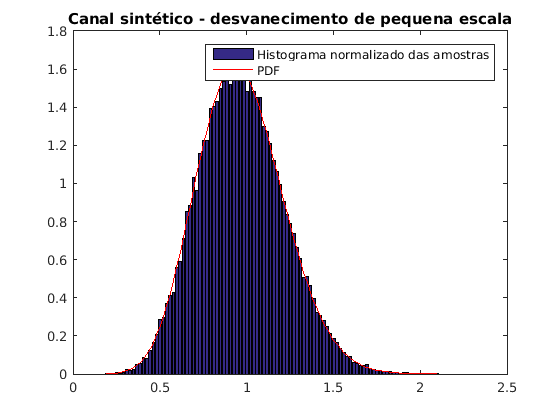

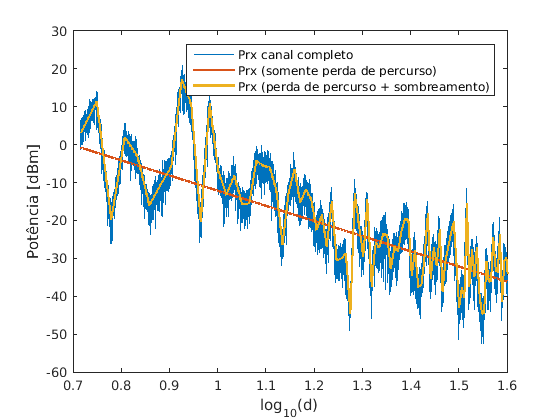

In [1]:
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
% Vetor de distâncias do transmissor (além da distância de referência)
vtDist = sPar.d0:sPar.dMed:sPar.totalLength;
% Número de amostras geradas
nSamples = length(vtDist);
% Geração da Perda de percurso (determinística)
vtPathLoss = sPar.P0 + 10*sPar.n*log10(vtDist./sPar.d0);
% Geração do Sombreamento (V.A. Gaussiana com média zero e desvio padrão sigma)
nShadowSamples = floor(nSamples/sPar.shadowingWindow);
vtShadowing = sPar.sigma*randn(1,nShadowSamples);
% Amostras para a última janela
restShadowing = sPar.sigma*randn(1,1)*ones(1,mod(nSamples,sPar.shadowingWindow));
% Repetição do mesmo valor de sombreamento durante a janela de correlação
vtShadowing = ones(sPar.shadowingWindow,1)*vtShadowing;
% Amostras organizadas em um vetor
vtShadowing = [reshape(vtShadowing,1,nShadowSamples*sPar.shadowingWindow),restShadowing];
% Filtragem para evitar variação abrupta do sombreamento (filtro média móvel)
% O sombreamento tem menos "2*jan" amostras devido a filtragem
jan = sPar.shadowingWindow/2;
iCont = 1;
for i = jan+1:nSamples-jan,
    vtShadCorr(iCont) = mean(vtShadowing(i-jan:i+jan));
    iCont = iCont+1;
end
% Ajuste do desvio padrão depois do filtro de correlação do sombreamento
vtShadCorr = vtShadCorr*std(vtShadowing)/std(vtShadCorr);
vtShadCorr = vtShadCorr - mean(vtShadCorr)+ mean(vtShadowing);
%
% Geração do desvanecimento de pequena escala: Nakagami fading
% PDF da envolvtória normalizada
fpNakaPdf = @(x)((2.*sPar.m.^sPar.m)./(gamma(sPar.m))).*x.^(2.*sPar.m-1).*exp(-(sPar.m.*x.^2));
% Gerador de números aleatórios com distribuição Nakagami
vtNakagamiNormEnvelope = slicesample(1,nSamples,'pdf',fpNakaPdf);
% Fading em dB (Potência)
vtNakagamiSampdB = 20.*log10(vtNakagamiNormEnvelope');
%
% Cálculo da Potência recebida
vtTxPower = sPar.txPower*ones(1,nSamples);
% Ajuste do número de amostras devido ao filtro de correlação do
% sombreamento (tira 2*"Jan" amostras)
vtTxPower = vtTxPower(jan+1:nSamples-jan);
vtPathLoss = vtPathLoss(jan+1:nSamples-jan);
vtFading = vtNakagamiSampdB(jan+1:nSamples-jan);
vtDist = vtDist(jan+1:nSamples-jan);
% Potência recebida
vtPrx = vtTxPower-vtPathLoss+vtShadCorr+vtFading;
%
% Salvamento dos dados
%    Para excel:
dlmwrite([sPar.chFileName '.txt'], [vtDist',vtPrx'], 'delimiter', '\t');
%    Matlab
save([sPar.chFileName '.mat'],'vtDist', 'vtPathLoss', 'vtShadCorr', 'vtFading', 'vtPrx');
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Plot do desvanecimento de larga escala (gráfico linear)
figure;
% Log da distância
log_distancia = log10(vtDist);
% Potência recebida com canal completo
plot(log_distancia,vtPrx); hold all;
% Potência recebida com path loss
plot(log_distancia,sPar.txPower-vtPathLoss,'linewidth', 2)
% Potência recebida com path loss e shadowing
plot(log_distancia,sPar.txPower-vtPathLoss+vtShadCorr,'linewidth', 2)
%title('Canal sintético: Potência recebida no receptor vs. log da distância')
xlabel('log_{10}(d)');
ylabel('Potência [dBm]');
legend('Prx canal completo', 'Prx (somente perda de percurso)', 'Prx (perda de percurso + sombreamento)');
xlim([0.7 1.6])
%
% Plot da geração do desvanecimento Nakagami
figure;
[f,x] = hist(vtNakagamiNormEnvelope,100);
bar(x,f/trapz(x,f)); % Histograma normalizado = PDF (das amostras)
hold all;
plot(x,fpNakaPdf(x),'r'); % PDF da distribuição
title('Canal sintético - desvanecimento de pequena escala');
legend('Histograma normalizado das amostras','PDF');

**A execução do código resulta em:**
1. Mensagem de texto com informações sobre o canal sintético gerado;
2. Os seguinte vetores:
 - vtDist: Pontos de medição [m];
 - vtPathLoss: Amostras da perda de percurso; 
 - vtShadCorr: Amostras do sombreamento;
 - vtFading: Amostras do desvanecimento de pequena escala;
 - vtPrx: Potência recebida com o canal completo.
3. Um arquivo .mat com nome especificado no parâmetro **sPar.fileName**;
4. Um gráfico mostrando a potência recebida com desvanecimento de larga e pequena escalas;
5. Gráfico com histograma e PDF m-Nakagami do desvanecimento de pequena escala.
 
** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

## Prática 02: Estimação do parâmetros do canal

Vamos escrever um código para, de posse do sinal medido, estimarmos a Perda de Percurso (modelo decaimento logaritmo), o Sombreamento Log-Normal (seu desvio padrão) e Desvanecimento de pequena escala (sua distribuição e parâmetros). O código deve ser parametrizável e gráficos devem ilustrar o comportamento de cada parte do sinal original e estimado.

**Passo 01:** Crie uma função chamada **fGeraCanal.m** com o código a seguir. Ele é uma versão do código **handson3_P1_1.m** escrito em forma de função. Isso foi feito para melhor organizar o código da prática 02.

In [2]:
%%file fGeraCanal.m
function [vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar)
% Propósito: Gerar canal composta de path loss, shadowing e desvanecimento plano
%
% ENTRADAS: na estrutura sParams
%    - nPoints: Número de amostras
%    - totalLength: distância máxima da rota
%    - P0: potência de referência medida na distância d0
%    - d0: distância d0 de referência
%    - n: expoente de perda de percurso
%    - sigma: desvio padrão do sombreamento lognormal [dB]
%    - Tamanho da janela de correlação do sombreamento [amostras]
%    - m: parâmetro de Nakagami
%    - dMed: distância entre pontos de medição (totalLength/nPoints)
%    - txPower: potência de transmissão em dBm
%
% SAÍDAS:
%    - vtDist: pontos de medição [m]
%    - vtPathLoss: amostras da perda de percurso
%    - vtShadCorr: amostras do somrbeamento
%    - fading: amostras do desvanecimento de pequena escala
%    - vtPrx: potência recebida com o canal completo
%
% Parser dos parâmetros de entrada
nPoints = sPar.nPoints;
totalLength = sPar.totalLength;
P0 = sPar.P0;
d0 = sPar.d0;
n = sPar.n;
sigma = sPar.sigma;
shadowingWindow = sPar.shadowingWindow;
m = sPar.m;
dMed = sPar.dMed;
txPower = sPar.txPower;
%
% Distância do transmissor (além da distância de referência)
d = d0:dMed:totalLength;
nSamples = length(d);
%
% Geração da Perda de percurso (determinística)
vtPathLoss = P0 + 10*n*log10(d./d0);
%
% Geração do Sombreamento
nShadowSamples = floor(nSamples/shadowingWindow);
shadowing = sigma*randn(1,nShadowSamples);
% Amostras para a última janela
restShadowing = sigma*randn(1,1)*ones(1,mod(nSamples,shadowingWindow));
% Repetição do mesmo valor de sombreamento durante a janela de correlação
shadowing = ones(shadowingWindow,1)*shadowing;
% Amostras organizadas em um vetor
shadowing = [reshape(shadowing,1,nShadowSamples*shadowingWindow),restShadowing];
% Filtragem para evitar variação abrupta do sombreamento
jan = shadowingWindow/2;
iCont = 1;
for i = jan+1:nSamples-jan,
    vtShadCorr(iCont) = mean(shadowing(i-jan:i+jan)); %diminuir a variação brusca do sombreamento
    iCont = iCont+1;
end
% Ajuste do desvio padrão depois do filtro de correlação do sombreamento
vtShadCorr = vtShadCorr*std(shadowing)/std(vtShadCorr);
vtShadCorr = vtShadCorr - mean(vtShadCorr)+ mean(shadowing);
%
% Geração do desvanecimento de pequena escala
% Nakagami fading
nakagamiPdf = @(x)((2.*m.^m)./(gamma(m))).*x.^(2.*m-1).*exp(-(m.*x.^2));
nakagamiNormEnvelope = slicesample(1,nSamples,'pdf',nakagamiPdf);
nakagamiSamp=20.*log10(nakagamiNormEnvelope');
%
% Cálculo da Potência recebida
txPower = txPower*ones(1,nSamples);
% Ajuste do número de amostras devido a filtragem
txPower = txPower(jan+1:nSamples-jan);
vtPathLoss = vtPathLoss(jan+1:nSamples-jan);
vtFading = nakagamiSamp(jan+1:nSamples-jan);
vtDist = d(jan+1:nSamples-jan);
% Potência recebida
vtPrxdBm = txPower-vtPathLoss+vtShadCorr+vtFading;
% Salva variáveis do canal no Matlab
save([sPar.chFileName '.mat'],'vtDist', 'vtPathLoss', 'vtShadCorr', 'vtFading', 'vtPrxdBm');

Created file '/home/gppcom/2019/EEC1714/fGeraCanal.m'.


**Passo 02:** Crie um script chamado **handson3_P2_1.m** com o código a seguir. Nesse código, vamos:

1. Separar o desvanecimento de larga e pequena escalas. Para isso, faça:
 - De posse da série temporal que representa a potência recebida **vtPrx**, passe um filtro média móvel com janela especificada no parâmetro **sPar.dW**;
 - A saída do filtro será o desvanecimento de larga escala estimado **vtDesLarga**. Ele é a perda de percurso somanda com o sombreamento;
 - Para cálcular a série temporal que representa o desvanecimento de pequena escala, é só subtrair o desvanecimento de larga escala estimado da potência recebida **vtPrx** - **vtDesLarga**; 
2. Usar interpolação linear em **vtPrx** para estimar a perda de percurso **vtPathLossEst**;
3. Informar o expooente de perda de percurso estimado;
4. Fazer um gráfico da perda de percurso original e estimada (comparação visual);
5. De posse da perda de percurso e do desvanecimento de larga escala, calcular a série temporal que representa o sombreamento: **vtDesLarga** - **vtPathLossEst**;
6. Fazer gráficos comparando cada série estimada com seu par original;
7. Estimar a CDF normalizada do desvanecimento de pequena escala e comparar com a formulação teórica do m-Nakagami para alguns valores de $m$.

Estimação dos parâmetros de larga escala (W = 100):
   Expoente de perda de percurso estimado n = 4.0028
   Desvio padrão do sombreamento estimado = 5.6611
   Média do sombreamento estimado = 0.77029


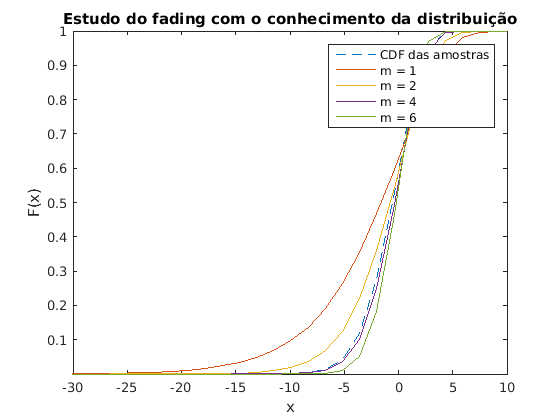

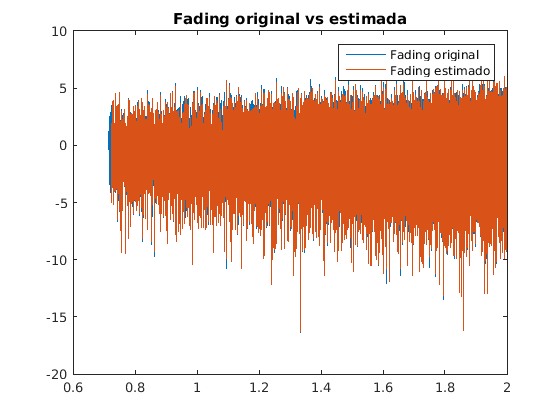

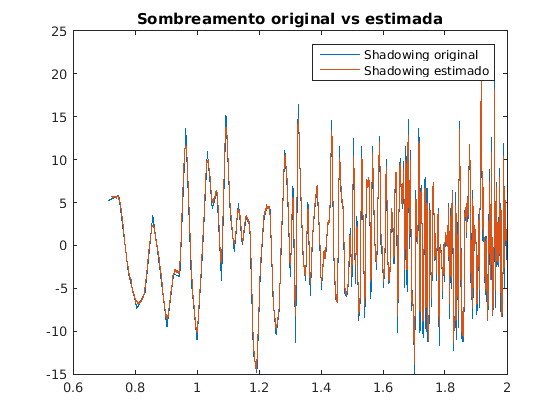

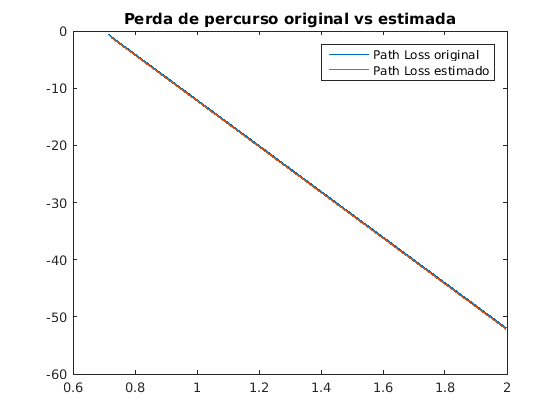

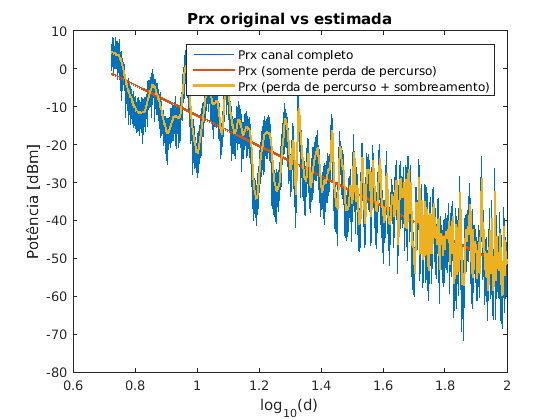

In [4]:
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
% Chama função que gera o canal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
% Transforma potência em mWatts
vtPtrxmW = 10.^(vtPrxdBm/10);
nSamples = length(vtPtrxmW);
% Vetores para canal estimado
vtDesLarga = [];
vtDesPequeEst = [];
%
% Cálculo do desvanecimenro lento e rápido
dMeiaJanela = round((sPar.dW-1)/2);  % Meia janela
ij = 1;
for ik = dMeiaJanela + 1 : nSamples - dMeiaJanela
    % Desvanecimento de larga escala: perda de percurso + sombreamento [dB]
    vtDesLarga(ij) = 10*log10(mean(vtPtrxmW(ik-dMeiaJanela:ik+dMeiaJanela)));
    % Desvanecimento de pequena escala [dB]
    vtDesPequeEst(ij) = vtPrxdBm(ik)-vtDesLarga(ij);
    ij = ij + 1;
end
%
% Cálculo da envoltória normalizada (para efeitos de cálculo do fading)
indexes = dMeiaJanela+1 : nSamples-dMeiaJanela;
%vtPrxW = ((10.^(vtPrxdBm(indexes)./10))/1000);
vtPtrxmWNew = 10.^(vtPrxdBm(indexes)/10);
desLarga_Lin = (10.^(vtDesLarga(1:length(indexes))./10));
envNormal = sqrt(vtPtrxmWNew)./sqrt(desLarga_Lin);
%
% Ajuste no tamanho dos vetores devido a filtragem
vtDistEst = vtDist( dMeiaJanela+1 : nSamples-dMeiaJanela );
vtPrxdBm = vtPrxdBm( dMeiaJanela+1 : nSamples-dMeiaJanela );
%
% Cálculo reta de perda de percurso
vtDistLog = log10(vtDist);
vtDistLogEst = log10(vtDistEst);
% Cálculo do coeficientes da reta que melhor se caracteriza a perda de percurso
dCoefReta = polyfit(vtDistLogEst,vtPrxdBm,1); 
% Expoente de perda de percurso estimado
dNEst = -dCoefReta(1)/10;
disp(['Estimação dos parâmetros de larga escala (W = ' num2str(sPar.dW) '):'])
disp(['   Expoente de perda de percurso estimado n = ' num2str(dNEst)]);
% Perda de percurso estimada para os pontos de medição
vtPathLossEst = polyval(dCoefReta,vtDistLogEst);  
%
% Sombreamento
vtShadCorrEst = vtDesLarga - vtPathLossEst;
% Calcula a variância do sombreamento estimado
stdShad = std(vtShadCorrEst);
meanShad = mean(vtShadCorrEst);
disp(['   Desvio padrão do sombreamento estimado = ' num2str(stdShad)]);
disp(['   Média do sombreamento estimado = ' num2str(meanShad)]);
vtPathLossEst = - vtPathLossEst;
vtPrxEst = sPar.txPower - vtPathLossEst + vtShadCorrEst + vtDesPequeEst;
%
% Estimação da CDF do desvanecimento de pequena escala
% Cálculo dos pontos do eixo x da cdf (espacamento igual entre os pontos)
vtn = 1 : sPar.nCDF;
xCDF = 1.2.^(vtn-1) * 0.01;
%
% Cálculo da CDF
den = 0;
cdffn=zeros(1,sPar.nCDF);
for ik = 1:sPar.nCDF
    for ij = 1:length(envNormal)
        if envNormal(ij) <= xCDF(ik)
            den = den + 1;
        end
        cdffn(ik) = cdffn(ik) + den;
        den = 0;
    end
end
%
% Monta estrutura do histograma
xccdfEst = 20.*log10(xCDF);
yccdfEst = cdffn/(cdffn(end)); 
% Figuras do canal estimado
figure;
% Potência recebida com canal completo
plot(vtDistLogEst,vtPrxEst); hold all;
% Potência recebida com path loss
plot(vtDistLogEst,sPar.txPower-vtPathLossEst,'linewidth', 2)
% Potência recebida com path loss e shadowing
plot(vtDistLogEst,sPar.txPower-vtPathLossEst+vtShadCorrEst,'linewidth', 2)
%title('Canal estimado: Potência recebida no receptor vs. log da distância')
xlabel('log_{10}(d)');
ylabel('Potência [dBm]');
legend('Prx canal completo', 'Prx (somente perda de percurso)', 'Prx (perda de percurso + sombreamento)');
title('Prx original vs estimada');
%
% Figura do Path loss (original vs estimado) 
figure;
plot(vtDistLog,-vtPathLoss);hold on;plot(vtDistLogEst,-vtPathLossEst);
legend('Path Loss original','Path Loss estimado');
title('Perda de percurso original vs estimada');
%
% Figura do Sombreamento (original vs estimado) 
figure;
plot(vtDistLog,vtShadCorr);hold on;plot(vtDistLogEst,vtShadCorrEst);
legend('Shadowing original','Shadowing estimado');
title('Sombreamento original vs estimada');
%
% Figura do Fading (original vs estimado) 
figure;
plot(vtDistLog,vtFading);hold on;plot(vtDistLogEst,vtDesPequeEst);
legend('Fading original','Fading estimado');
title('Fading original vs estimada');
%
% Plot das CDFs normalizadas Nakagami (assumindo que sabemos que o canal é m-Nakagami)- para vários valores de m
figure;
plot( xccdfEst, yccdfEst, '--' );
legendaNaka = [{'CDF das amostras'}];
hold all;
vtm = [1 2 4 6];
xCDF = 10.^(xccdfEst/20);
tam_dist = length(gammainc(1*xCDF.^2,1)); % Tamanho da distribuição
for ik = 1:length(vtm)%
    im = vtm(ik);
    cdfnaka(ik,1:tam_dist) = gammainc(im*xCDF.^2,im);
    semilogy(20.*log10(xCDF),cdfnaka(ik,:));
    legendaNaka = [legendaNaka ; {['m = ' num2str(vtm(ik))]}];
end
legend(legendaNaka);
axis([-30 10 1e-5 1]);
title('Estudo do fading com o conhecimento da distribuição');
xlabel('x');
ylabel('F(x)');

## Prática 03: Influência da janela de filtragem para separação dos desvanecimentos de larga e pequena escalas e estimação da distribuição do fading

Vamos escrever um código para estimar o desvanecimento de pequena escala (sua distribuição e parâmetros) e investigar a influência do tamanho da janela de filtragem para separação dos desvanecimentos de larga e pequena escalas. O código irá aplicar alguns testes estatísticos e fará um estudo com o conhecimento a priori do canal e sem seu conhecimento.

**Passo 01:** Crie uma função chamada **fGeraCanal.m** da prática 02.


**Passo 02:** Crie uma função chamada **fEstimaCanal.m** com o código a seguir. Ele é uma versão do código **handson3_P2_1.m** escrito em forma de função. Isso foi feito para melhor organizar o código da prática 03.



In [14]:
%%file fEstimaCanal.m
function [sOut] = fEstimaCanal(sPar)
% PURPOSE: Estima parâmetros do canal: path loss, shadowing e desvanecimento plano
%
% ENTRADAS: na estrutura sPar
%    - P0: potência de referência medida na distância d0
%    - d0: distância d0 de referência
%    - shadWindowFilter: janela para média móvel do desvanecimento da larga
%    escala
%    - txPower: potência de transmissão em dBm
%    - nCDF: Número de pontos da CDF normalizada
%
% SAÍDAS: Estrutura sOut com
%    - vtDist: pontos de medição [m]
%    - vtPathLossEst: amostras estimadas da perda de percurso
%    - vtShadCorr: amostras do somrbeamento
%    - vtDesPequeEst: amostras do desvanecimento de pequena escala
%    - vtPrxEst: potência recebida estimada (canal completo)
%    - dNEst: Expoente de perda de percurso estimado
%    - dStdShadEst: Desvio padrão do shadwoing estimado
%    - dStdMeanShadEst: Média do shadwoing estimado
%    - vtXCcdfEst: Valores dos Bins da CCDF do desvanecimento de pequena escala 
%    - vtYCcdfEst: Quantidade de amostras em cada bin da CCDF do desvanecimento de pequena escala

% Lê canal gerado
load(sPar.chFileName);
%
vtPtrxmW = 10.^(vtPrxdBm/10);
nSamples = length(vtPtrxmW);
% Vetores para canal estimado
vtDesLarga = [];
vtDesPequeEst = [];
%
% Cálculo do desvanecimenro lento e rápido
dMeiaJanela = round((sPar.dW-1)/2);  % Meia janela
ij = 1;
for ik = dMeiaJanela + 1 : nSamples - dMeiaJanela
    % Desvanecimento de larga escala: perda de percurso + sombreamento [dB]
    vtDesLarga(ij) = 10*log10(mean(vtPtrxmW(ik-dMeiaJanela:ik+dMeiaJanela)));
    % Desvanecimento de pequena escala [dB]
    vtDesPequeEst(ij) = vtPrxdBm(ik)-vtDesLarga(ij);
    ij = ij + 1;
end
%
% Cálculo da envoltória normalizada (para efeitos de cálculo do fading)
indexes = dMeiaJanela+1 : nSamples-dMeiaJanela;
%vtPrxW = ((10.^(vtPrxdBm(indexes)./10))/1000);
vtPtrxmWNew = 10.^(vtPrxdBm(indexes)/10);
desLarga_Lin = (10.^(vtDesLarga(1:length(indexes))./10));
vtEnvNorm = sqrt(vtPtrxmWNew)./sqrt(desLarga_Lin);
%
% Ajuste no tamanho dos vetores devido a filtragem
vtDistEst = vtDist( dMeiaJanela+1 : nSamples-dMeiaJanela );
vtPrxdBm = vtPrxdBm( dMeiaJanela+1 : nSamples-dMeiaJanela );
%
% Cálculo reta de perda de percurso
vtDistLog = log10(vtDist);
vtDistLogEst = log10(vtDistEst);
% Cálculo do coeficientes da reta que melhor se caracteriza a perda de percurso
dCoefReta = polyfit(vtDistLogEst,vtPrxdBm,1); 
% Expoente de perda de percurso estimado
dNEst = -dCoefReta(1)/10;
% Perda de percurso estimada para os pontos de medição
vtPathLossEst = polyval(dCoefReta,vtDistLogEst);  
%
% Sombreamento
vtShadCorrEst = vtDesLarga - vtPathLossEst;
% Calcula a variância do sombreamento estimado
dStdShadEst = std(vtShadCorrEst);
dStdMeanShadEst = mean(vtShadCorrEst);
vtPathLossEst = - vtPathLossEst;
vtPrxEst = sPar.txPower - vtPathLossEst + vtShadCorrEst + vtDesPequeEst;
%
% Estimação da CDF do desvanecimento de pequena escala
% Cálculo dos pontos do eixo x da cdf (espacamento igual entre os pontos)
vtn = 1 : sPar.nCDF;
xCDF = 1.2.^(vtn-1) * 0.01;
%
% Cálculo da CDF
den = 0;
cdffn=zeros(1,sPar.nCDF);
for ik = 1:sPar.nCDF
    for ij = 1:length(vtEnvNorm)
        if vtEnvNorm(ij) <= xCDF(ik)
            den = den + 1;
        end
        cdffn(ik) = cdffn(ik) + den;
        den = 0;
    end
end
%
% Monta estrutura do histograma
vtXCcdfEst = 20.*log10(xCDF);
vtYCcdfEst = cdffn/(cdffn(end)); 
%
sOut.vtDistEst = vtDistEst;
sOut.vtPathLossEst = vtPathLossEst;
sOut.dNEst = dNEst;
sOut.vtShadCorrEst = vtShadCorrEst;
sOut.dStdShadEst = dStdShadEst;
sOut.dStdMeanShadEst = dStdMeanShadEst;
sOut.vtDesPequeEst = vtDesPequeEst;
sOut.vtPrxEst = vtPrxEst;
sOut.vtXCcdfEst = vtXCcdfEst;
sOut.vtYCcdfEst = vtYCcdfEst;
sOut.vtEnvNorm = vtEnvNorm;

Created file '/home/gppcom/2019/EEC1714/fEstimaCanal.m'.


**Passo 03:** Crie um script chamado **handson3_P3_1.m** com o código a seguir. Nesse código, vamos:

1. Gerar um canal sintético;
2. Estimar os parâmetros do canal para vários valores de janela de filtragem para separação dos desvanecimentos de larga e pequena escalas. Os valores das janelas podem ser configurados em **vtW**;
3. De posse das séries temporais estimadas e da séries originais, calcular o MSE do shadowing e do desvanecimento de pequena escala para cada janela;
4. Mostrar as janelas com menor MSE.

In [9]:
close all;clear all;clc;
% Estimação com o conhecimento do sombreamento e do fading
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
%
% Chama função que gera o canal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Várias janelas de filtragem para testar a estimação
vtW = [10 50 150 200];
for iw = 1: length(vtW)
    % Configura valor da janela de filtragem
    sPar.dW = vtW(iw);
    % Chama função que estima o canal sintético
    [sOut] = fEstimaCanal(sPar);
    % Parser de variáveis
    vtDistEst = sOut.vtDistEst;
    vtPathLossEst = sOut.vtPathLossEst;
    dNEst = sOut.dNEst;
    vtShadCorrEst = sOut.vtShadCorrEst;
    dStdShadEst = sOut.dStdShadEst;
    dStdMeanShadEst = sOut.dStdMeanShadEst;
    vtDesPequeEst = sOut.vtDesPequeEst;
    vtPrxEst = sOut.vtPrxEst;
    vtXCcdfEst = sOut.vtXCcdfEst;
    vtYCcdfEst = sOut.vtYCcdfEst;
    vtDistLogEst = log10(vtDistEst);
    vtDistLog = log10(vtDist);
    % MSE com Shadowing conhecido
    dMeiaJanela = round((sPar.dW-1)/2);
    vtMSEShad(iw) = immse(vtShadCorr(dMeiaJanela+1 : end-dMeiaJanela ), vtShadCorrEst);
    %
    % MSE com Fading conhecido
    vtMSEFad(iw) = immse(vtFading(dMeiaJanela+1 : end-dMeiaJanela ), vtDesPequeEst);
    %
    disp(['Estimação dos parâmetros de larga escala (W = ' num2str(sPar.dW) '):'])
    disp(['   Expoente de perda de percurso estimado n = ' num2str(dNEst)]);
    disp(['   Desvio padrão do sombreamento estimado = ' num2str(dStdShadEst)]);
    disp(['   Média do sombreamento estimado = ' num2str(dStdMeanShadEst)]);
    disp(['   MSE Shadowing = ' num2str(vtMSEShad(iw))]);
    disp('----');
    disp(' ');
end
% Display informação sobre o estudo das janelas
disp(['Estudo na melhor janela de filtragem']);
disp(['   Janelas utilizadas = ' num2str(vtW)]);
% Melhor janela com Shadowing conhecido
[valBestShad, posBestShad] = min(vtMSEShad);
disp(['   Melhor MSE relativo aos valores reais do Shadowing (melhor janela):'])
disp(['      Melhor janela W = ' num2str(vtW(posBestShad)) ': MSE Shadowing = ' num2str(valBestShad)]);
% Melhor janela com Fading conhecido
[valBestFad, posBestFad] = min(vtMSEFad);
disp(['   Melhor MSE relativo aos valores reais do Fading:'])
disp(['      Melhor janela W = ' num2str(vtW(posBestFad)) ': MSE Shadowing = ' num2str(valBestFad)]);
disp('----------------------------------------------------------------------------------');
disp(' ');

Canal sintético:
   Média do sombreamento: -0.24937
   Std do sombreamento: 6.0232
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4
Estimação dos parâmetros de larga escala (W = 10):
   Expoente de perda de percurso estimado n = 4.0427
   Desvio padrão do sombreamento estimado = 6.0494
   Média do sombreamento estimado = 0.50963
   MSE Shadowing = 1.0547
----
 
Estimação dos parâmetros de larga escala (W = 50):
   Expoente de perda de percurso estimado n = 4.0436
   Desvio padrão do sombreamento estimado = 5.9757
   Média do sombreamento estimado = 0.61699
   MSE Shadowing = 0.90491
----
 
Estimação dos parâmetros de larga escala (W = 150):
   Expoente de perda de percurso estimado n = 4.047
   Desvio padrão do sombreamento estimado = 5.6859
   Média do sombreamento estimado = 1.0424
   MSE Shadowing = 2.7487
----
 
Estimação dos parâmetros de larga escala (W = 200):
   Expoente de perda de percurso estimado n = 4.0496
   Desvio padr

**A execução do código resulta em:**
1. Mensagens de texto com informações sobre o canal sintético gerado;
2. Mensagens de texto com informações sobre o canal estimado com cada valor de janela de filtragem;

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

**Passo 03:** Crie um script chamado **handson3_P3_2.m** com o código a seguir. Nesse código, vamos manter o mesmo código do **handson3_P3_1.m** e acrescentar:

1. Estimar a melhor janela pelo MSE da CDF do desvanecimento de pequena escala para vários valores de janela de filtragem e vários valores do $m$ de Nakagami (comparar com o resultado do passo anterior);
2. Mostrar a CDF do desvanecimento de pequena escala para os vários valores de janela de filtragem.

Canal sintético:
   Média do sombreamento: 0.68848
   Std do sombreamento: 6.2298
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4
Estimação dos parâmetros de larga escala (W = 10):
   Expoente de perda de percurso estimado n = 3.9584
   Desvio padrão do sombreamento estimado = 6.2534
   Média do sombreamento estimado = 0.51793
   MSE Shadowing = 0.50302
----
 
Estimação dos parâmetros de larga escala (W = 50):
   Expoente de perda de percurso estimado n = 3.9572
   Desvio padrão do sombreamento estimado = 6.1784
   Média do sombreamento estimado = 0.62476
   MSE Shadowing = 0.15847
----
 
Estimação dos parâmetros de larga escala (W = 150):
   Expoente de perda de percurso estimado n = 3.9583
   Desvio padrão do sombreamento estimado = 5.8411
   Média do sombreamento estimado = 1.0492
   MSE Shadowing = 1.1417
----
 
Estimação dos parâmetros de larga escala (W = 200):
   Expoente de perda de percurso estimado n = 3.9601
   Desvio pad

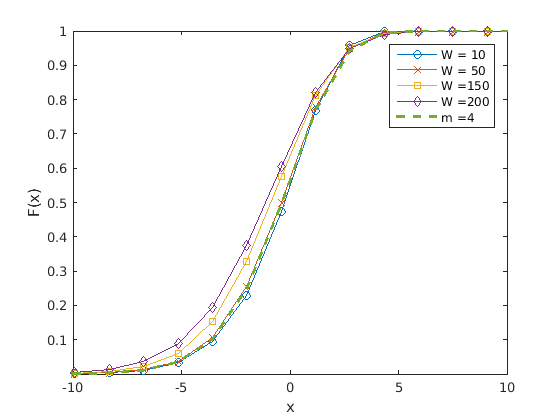

In [10]:
close all;clear all;clc;
% Estimação com o conhecimento do sombreamento e do fading
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
%
% Chama função que gera o canal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Várias janelas de filtragem para testar a estimação
vtW = [10 50 150 200];
for iw = 1: length(vtW)
    % Configura valor da janela de filtragem
    sPar.dW = vtW(iw);
    % Chama função que estima o canal sintético
    sOut(iw) = fEstimaCanal(sPar);
    % Parser de variáveis
    vtDistEst = sOut(iw).vtDistEst;
    vtPathLossEst = sOut(iw).vtPathLossEst;
    dNEst = sOut(iw).dNEst;
    vtShadCorrEst = sOut(iw).vtShadCorrEst;
    dStdShadEst = sOut(iw).dStdShadEst;
    dStdMeanShadEst = sOut(iw).dStdMeanShadEst;
    vtDesPequeEst = sOut(iw).vtDesPequeEst;
    vtPrxEst = sOut(iw).vtPrxEst;
    vtXCcdfEst = sOut(iw).vtXCcdfEst;
    vtYCcdfEst = sOut(iw).vtYCcdfEst;
    vtDistLogEst = log10(vtDistEst);
    vtDistLog = log10(vtDist);
    % MSE com Shadowing conhecido
    dMeiaJanela = round((sPar.dW-1)/2);
    vtMSEShad(iw) = immse(vtShadCorr(dMeiaJanela+1 : end-dMeiaJanela ), vtShadCorrEst);
    %
    % MSE com Fading conhecido
    vtMSEFad(iw) = immse(vtFading(dMeiaJanela+1 : end-dMeiaJanela ), vtDesPequeEst);
    %
    disp(['Estimação dos parâmetros de larga escala (W = ' num2str(sPar.dW) '):'])
    disp(['   Expoente de perda de percurso estimado n = ' num2str(dNEst)]);
    disp(['   Desvio padrão do sombreamento estimado = ' num2str(dStdShadEst)]);
    disp(['   Média do sombreamento estimado = ' num2str(dStdMeanShadEst)]);
    disp(['   MSE Shadowing = ' num2str(vtMSEShad(iw))]);
    disp('----');
    disp(' ');
end
% Display informação sobre o estudo das janelas
disp(['Estudo na melhor janela de filtragem']);
disp(['   Janelas utilizadas = ' num2str(vtW)]);
% Melhor janela com Shadowing conhecido
[valBestShad, posBestShad] = min(vtMSEShad);
disp(['   Melhor MSE relativo aos valores reais do Shadowing (melhor janela):'])
disp(['      Melhor janela W = ' num2str(vtW(posBestShad)) ': MSE Shadowing = ' num2str(valBestShad)]);
% Melhor janela com Fading conhecido
[valBestFad, posBestFad] = min(vtMSEFad);
disp(['   Melhor MSE relativo aos valores reais do Fading:'])
disp(['      Melhor janela W = ' num2str(vtW(posBestFad)) ': MSE Shadowing = ' num2str(valBestFad)]);
disp('----------------------------------------------------------------------------------');
disp(' ');
%
% Estudo visual: Estimação do Fading para várias janelas de filtragem e
% vários valores do m de Nakagami
%
% Plot das CCDFs do Fading para cada janela
figure;
chMarkers = ['o-';'x-';'s-';'d-';'>-';'^-';'-.'];
for iw = 1:length(vtW)
    plot( sOut(iw).vtXCcdfEst,  sOut(iw).vtYCcdfEst, chMarkers(iw,:) ); hold all;
end
chLegendaW = strcat('W = ',cellstr(num2str(vtW')));
legend(chLegendaW);
xlabel('x');
ylabel('F(x)');
%
% Plot das CDFs Nakagami teórica o valor do m de entrada
vtm = sPar.m;
xCDF = 10.^(sOut(1).vtXCcdfEst/20);
tam_dist = length(gammainc(1*xCDF.^2,1)); % Tamanho da distribuição
for ik = 1:length(vtm)
    im = vtm(ik);
    cdfnaka(ik,1:tam_dist) = gammainc(im*xCDF.^2,im);
    semilogy(20.*log10(xCDF),cdfnaka(ik,:),'--', 'linewidth', 2);
    chLegendaNaka = strcat('m = ',cellstr(num2str(vtm'))); %criação da legenda automática
end
legend([chLegendaW; chLegendaNaka]);
axis([-10 10 1e-5 1]);
% Cálculo do erro médio baseado na comparação de CDFs 
disp('MSE da CDF com várias janelas de filtragem com o conhecimento do Fading:')
% Cálculo do erro médio quadrático da CDF do Fading
vtm = [2:1:5];
for ik = 1:length(vtm)
    im = vtm(ik);
    cdfnaka(ik,1:tam_dist) = gammainc(im*xCDF.^2,im);
    for il = 1:length(vtW)
        mtMSEFad(ik,il) = immse(cdfnaka(ik,:), sOut(il).vtYCcdfEst);
        disp(['   m = ' num2str(vtm(ik)) ', W = ' num2str(vtW(il)) ': MSE Fading = ' num2str(mtMSEFad(ik,il))]);
    end
    disp('----');
end
[vLinha, posLinha] = min(mtMSEFad); % Melhor m para cada W
[valCol, posCol] = min(vLinha); % Melhor W de todos (entre os com menores m)
bestLin = posLinha(posCol);
bestCol = posCol;
disp(['   Melhor MSE relativo aos valores reais do fading:'])
disp(['   W = ' num2str(vtW(bestCol)) ' e m = ' num2str(vtm(bestLin)) ': MSE Fading = ' num2str(mtMSEFad(bestLin, bestCol))]);
disp('----------------------------------------------------------------------------------');
disp(' ');

Até esse momento nos concentramos em estimar os parâmetros do canal com o conhecimento a priori da série temporal do sombreamento e do desvnecimento de pequena escala. Contudo, para estimação de canal baseado em uma medição de campo (e não de um sinal sintético), esse conhecimento não é possível. Na verdade, conhecer as características estatísticas dessas séries temporais é a grande tarefa da estimação.  

Um método muito utilizado para estimação de parâmetros é o MLE (Maximum Likelihood Estimation). O MLE é um método de estimar os parâmetros ${\theta}$ de uma específica função distribuição de probabilidades $f(x_{i}|{\theta})$ de uma variável aleatória $X$ [[Fonte]](http://times.cs.uiuc.edu/course/410/note/mle.pdf). A estimação é baseada em amostras i.i.d. (independent and identically distributed) $x_{i}$ e na função  log-likelihood (máxima verossimilhança) definida como:

&nbsp; 
<center>
$\ell({\theta}) = \sum_{i=1}^{N} \log f (x_{i}| {\theta})$.
</center>

Então, o MLE escolhe os parâmetros $\hat{\theta}$ que maximiza a função de máxima verossimilhança, resultando nos parâmtros mais prováveis de gerar os dados observados [[Fonte]](https://www.jstage.jst.go.jp/article/iis/17/3/17_3_155/_pdf/-char/en).

Especificamente no MatLab, a função **fitdist** foi contruída para fazer o MLE [[Fonte]](https://www.mathworks.com/help/stats/fitdist.html#btu538h-pd).


**Passo 03:** Crie um script chamado **handson3_P3_3.m** com o código a seguir. Nesse código, vamos manter o mesmo código do **handson3_P3_2.m** e acrescentar:

1. Estimar via MLE os parâmetros das distribuição Nakagami, Rice, Rayleigh e Weibull para os dados do desvanecimento de pequena escala estimado para as várias janelas (usar comando **fitdist** do Matlab);
2. Além de constatar a possibilidade de parâmetros de para cada distribuição, inspecionaremos quais os parâmetros estimados para Nakagami, já que sabemos que esse é o tipo de canal gerado.

In [18]:
close all;clear all;clc;
% Estimação com o conhecimento do sombreamento e do fading
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
%
% Chama função que gera o canal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Várias janelas de filtragem para testar a estimação
vtW = [10 50 150 200];
for iw = 1: length(vtW)
    % Configura valor da janela de filtragem
    sPar.dW = vtW(iw);
    % Chama função que estima o canal sintético
    sOut(iw) = fEstimaCanal(sPar);
    % Parser de variáveis
    vtDistEst = sOut(iw).vtDistEst;
    vtPathLossEst = sOut(iw).vtPathLossEst;
    dNEst = sOut(iw).dNEst;
    vtShadCorrEst = sOut(iw).vtShadCorrEst;
    dStdShadEst = sOut(iw).dStdShadEst;
    dStdMeanShadEst = sOut(iw).dStdMeanShadEst;
    vtDesPequeEst = sOut(iw).vtDesPequeEst;
    vtPrxEst = sOut(iw).vtPrxEst;
    vtXCcdfEst = sOut(iw).vtXCcdfEst;
    vtYCcdfEst = sOut(iw).vtYCcdfEst;
    vtDistLogEst = log10(vtDistEst);
    vtDistLog = log10(vtDist);
end
% Estimação cega via MLE
disp(' ')
disp('Estimação do Fading para várias janelas (estudo númerico sem conhecimento a priori do canal)');
disp('Resultados com fitdist do Matlab')
for iw = 1:length(vtW)%
    disp(['Janela W = ' num2str(vtW(iw))]);
    %
    sNaka(iw) = fitdist([sOut(iw).vtEnvNorm]','Nakagami');
    disp(['  Nakagami: m = ' num2str(sNaka(iw).mu) ', omega = ' num2str(sNaka(iw).omega)]);
    %
    sRice(iw) = fitdist([sOut(iw).vtEnvNorm]','Rician');
    K_rice = (sRice(iw).s)^2/(2*sRice(iw).sigma^2);
    disp(['  Rice: K = ' num2str(K_rice)]);
    %
    sRay(iw) = fitdist([sOut(iw).vtEnvNorm]','Rayleigh');
    disp(['  Rayleigh: sigma = ' num2str(sRay(iw).B)]);
    %
    sWei(iw) = fitdist([sOut(iw).vtEnvNorm]','Weibull');
    disp(['  Weibull: k = ' num2str(sWei(iw).B) ', lambda = ' num2str(sWei(iw).A)]);
    disp(' ')
end

Canal sintético:
   Média do sombreamento: 0.14884
   Std do sombreamento: 5.8693
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4
 
Estimação do Fading para várias janelas (estudo númerico sem conhecimento a priori do canal)
Resultados com fitdist do Matlab
Janela W = 10
  Nakagami: m = 4.4196, omega = 0.99937
  Rice: K = 7.9449
  Rayleigh: sigma = 0.70688
  Weibull: k = 4.5836, lambda = 1.0628
 
Janela W = 50
  Nakagami: m = 4.0807, omega = 0.98601
  Rice: K = 7.1451
  Rayleigh: sigma = 0.70214
  Weibull: k = 4.3064, lambda = 1.0563
 
Janela W = 150
  Nakagami: m = 3.4946, omega = 0.92032
  Rice: K = 5.8693
  Rayleigh: sigma = 0.67835
  Weibull: k = 3.8966, lambda = 1.0205
 
Janela W = 200
  Nakagami: m = 2.9824, omega = 0.89177
  Rice: K = 4.7841
  Rayleigh: sigma = 0.66775
  Weibull: k = 3.5553, lambda = 1.0032
 


**A execução do código resulta em:**
1. Mensagens de texto com informações sobre o canal sintético gerado;
2. Mensagens de texto com informações sobre os parâmetros das distribuições Nakagami, Rice, Rayleigh e Weibull que melhor se adequam aos dados do desvanecimento de pequena escala. Observe que a melhor janela é W = 50, que o $m$ d Nakagami é exatamente igual a 4.

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**


Assim, baseado no MSE podemos inferir qual o conjunto de parâmetros de uma determinada distribuição que melhor representa os dados medidos. Contudo, isso não nos responde se esse distribuição é a mais adequada. Para responder tal questão, lançamos mão de um tese de hipóteses. Um teste de hipótese é uma metodologia estatística que nos auxilia a tomar decisões sobre uma ou mais populações baseado na informação obtida da amostra [[Fonte]](https://www.inf.ufsc.br/~andre.zibetti/probabilidade/teste-de-hipoteses.html).


Uma hipótese estatística é uma afirmação ou conjetura sobre o parâmetro, ou parâmetros, da distribuição de probabilidades de uma característica, $X$, da população ou de uma variável aleatória. Já um teste de uma hipóteses estatística é o procedimento ou regra de decisão que nos possibilita decidir por H0 (hipótese nula) ou Ha (hipótese alternativa), com base a informação contida na amostra (dados medidos). Assim, os dados observados de um determinado experimento são usados para definir **uma regra que rejeição ou não da hipótese nula**. 

Assim, defini-se a Região crítica (Rc) como o conjunto de valores assumidos pela variável aleatória ou por uma **estatística de teste** para os quais H0 (hipótese nula) é rejeitada [[Fonte]](https://www.ime.unicamp.br/~hlachos/Inferencia_Hipo1.pdf). Geralmente, essa **estatística de teste** está vinculada a algum limite de erro.

### Tipos de Erros

Na tomada de decisão conforme estabelecido acima, dado algum critério, podemos obviamente estar comentendo algum erro. Classicamente, esses erros são chamados de **erro do tipo I** e **erro do tipo II**:

 - **Erro do tipo I ($\alpha$)**: Rejeitar a hipótese nula H0 quando ela é verdadeira;
 - **Erro do tipo II**: Rejeitar a hipótese alternativa Ha quando ela é verdadeira.
 
 A tabela a seguir ilustra os dois tipos de erro.
 


|                 |  Ho Verdadeira   | H1 verdadeira   |
|:----------------|-----------------:|-----------------|
| **Não rejeitar Ho** |  Decisão correta ($1-\alpha$) | Erro tipo II ($\beta$)   |
| **Rejeitar Ho**    | Erro tipo I ($\alpha$)      | Decisão correta ($1-\beta$) |


A **probabilidade do Erro do tipo I**, ($\alpha$) é chamado de **nível de significância**, ou erro α, ou ainda tamanho do teste, definda como:

<center>
$\alpha$ = P(Erro do tipo I) = P(rejeitar H0|H0 verdadeira).
</center>

Já a **probabilidade do Erro do Tipo II** é:

<center>
$\beta$ = P(erro do tipo II) = P(não rejeitar H0|H0 falsa).
</center>

A **Potência ou Poder do Teste** ou potência é a probabilidade de rejeitar a hipótese nula H0, quando a hipótese alternativa H1 é verdadeira: 

<center>
(1−$\beta$) = P(rejeitar H0|H1 verdadeira)
</center>

A Figura a seguir ilustra os tipos de erro ao mostrar as distribuições de probabilidade de um **teste estatístico** para H0 e H1.

![fig_poder-do-teste](./FIGS/HD_02/poder-do-teste.png)


Note que quanto mais distantes as distribuições do **teste estatístico** para H0 e H1, menor será o erro.

Contudo, no caso de teste de hipóteses para aderência estatística, a hipótese H0 é que os dados medidos são de uma determinada distribuição de probabilidades, e Ha é que os dados não seguem essa distribuição. A definição do **teste estatístico** (seu cálculo e sua distribiução) define diferentes testes de hipóteses. Como esse decisão feita e com os dados coletados, deve-se definir um nível de significância alvo, calcular o **teste estatístico** e tomar a decisão comparando o valor de teste com um valor crítico. Os passos são os seguintes:


1. Definição as hipóteses H0 e H1;
2. Identificação do **teste estatístico** e caracterização da sua distribuição;
3. Definição  da  regra  de  decisão,  com a  especificação  do  nível  de significância do teste;
4. Cálculo da estatística de teste e tomada de decisão.

No passo 4, de posse do valor da estatística de tese e sua distribuição, pode-se calcular o Valor-P, como ilsutrado a seguir para uma estística de teste t = -1,3. Assim, rejeita-se H0 se o Valor−P (probabilidade de cometer o erro do Tipo I) for menor que $\alpha$. Geralmente, se define um valor baixo para $\alpha$, por exemplo, 0,05.


![fig_teste-de-hipoteses-exemplo-1bb-1](./FIGS/HD_02/teste-de-hipoteses-exemplo-1bb-1.png)


**Passo 03:** Crie um script chamado **handson3_P3_4.m** com o código a seguir. Nesse código, vamos manter o mesmo código do **handson3_P3_3.m** e acrescentar:

1. Usar o pacote **FitMeThis** [[Fonte]](https://www.mathworks.com/matlabcentral/fileexchange/40167-fitmethis) para achar a melhor distribuição para o desvanecimento de pequena escala,considerando as várias janelas de filtragem;
2. Comparar resultados com o que já foi testado até o momento.

In [20]:
close all;clear all;clc;
addpath('./CODES/HD_03_MATLAB/fitmethis')
% Estimação com o conhecimento do sombreamento e do fading
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
%
% Chama função que gera o canal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Várias janelas de filtragem para testar a estimação
vtW = [10 50 150 200];
for iw = 1: length(vtW)
    % Configura valor da janela de filtragem
    sPar.dW = vtW(iw);
    % Chama função que estima o canal sintético
    sOut(iw) = fEstimaCanal(sPar);
    % Parser de variáveis
    vtDistEst = sOut(iw).vtDistEst;
    vtPathLossEst = sOut(iw).vtPathLossEst;
    dNEst = sOut(iw).dNEst;
    vtShadCorrEst = sOut(iw).vtShadCorrEst;
    dStdShadEst = sOut(iw).dStdShadEst;
    dStdMeanShadEst = sOut(iw).dStdMeanShadEst;
    vtDesPequeEst = sOut(iw).vtDesPequeEst;
    vtPrxEst = sOut(iw).vtPrxEst;
    vtXCcdfEst = sOut(iw).vtXCcdfEst;
    vtYCcdfEst = sOut(iw).vtYCcdfEst;
    vtDistLogEst = log10(vtDistEst);
    vtDistLog = log10(vtDist);
end
% Estimação cega via FitMeThis
disp(' ')
disp('Estimação do Fading para várias janelas (estudo númerico sem conhecimento a priori do canal)');
disp('Resultados com FITMETHIS')
for iw = 1:length(vtW)%
    disp(['Janela W = ' num2str(vtW(iw))]);
    %
    fitWindow{iw} = fitmethis([sOut(iw).vtEnvNorm]','figure','off');
    disp(' ')
end

Canal sintético:
   Média do sombreamento: -0.36305
   Std do sombreamento: 5.3957
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4
 
Estimação do Fading para várias janelas (estudo númerico sem conhecimento a priori do canal)
Resultados com FITMETHIS
Janela W = 10

				Name		Par1		Par2		Par3		LogL		AIC
              rician 	 9.414e-01 	 2.375e-01 				 1.727e+03 	-3.449e+03
              normal 	 9.719e-01 	 2.334e-01 				 1.710e+03 	-3.415e+03
      tlocationscale 	 9.719e-01 	 2.334e-01 	 1.786e+06 	 1.710e+03 	-3.413e+03
            nakagami 	 4.382e+00 	 9.991e-01 				 1.641e+03 	-3.278e+03
                 gev 	-2.084e-01 	 2.277e-01 	 8.810e-01 	 1.572e+03 	-3.139e+03
             weibull 	 1.063e+00 	 4.559e+00 				 1.288e+03 	-2.572e+03
            logistic 	 9.705e-01 	 1.340e-01 				 1.146e+03 	-2.287e+03
               gamma 	 1.620e+01 	 6.000e-02 				 1.084e+03 	-2.163e+03
         loglogistic 	-4.411e-02 	 1.436e-01 			

**A execução do código resulta em:**
1. Mensagens de texto com informações sobre o canal sintético gerado;
2. Mensagens de texto com informações sobre os parâmetros das distribuições e um rank das melhores distribuições seguindo a métrica de máxima verosimilhança.

Observe que a melhor janela continua sendo W = 50 (menor valor absoluto de LogL), que o $m$ d Nakagami é exatamente igual a 4.

Pode ser que seja difícil de visualizar a saída do FitMeThis, devido ao tamanho da tela. Mas na saída da IDE do Matlab os dados ficam bem organizados. 

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**


Finalmente, vamos fazer o teste clássico Kolmogorov-Smirnov (teste KS) de aderência estatística. O teste KS compara o ECDF (função de distribuição acumulada empírica) de seus dados de amostra com a distribuição alvo. A estatística de teste é o maior valor de erro entre a ECDF e a CDF da distribuição alvo. Assim, o Valor-P é calulcado para medir a evidência contra a hipótese nula. Um Valor-P é comparado como o nível de significância e o resutlado do teste é mostrado. 

O teste de hipótese é configurado como:

 - H0: Os dados são da distribuição alvo;
 - H1: Os dados não são da distribuição alvo

Assim, se não rejeitarmos H0, os dados podem ser da distribuição especificada.

Como a estatśitica de teste $k$ é a maior diferença entre a CDF dos dados (ECDF) e da distribuição especificada, quanto menor k, melhor o fit.


**Passo 03:** Crie um script chamado **handson3_P3_5.m** com o código a seguir. Nesse código, vamos manter o mesmo código do **handson3_P3_4.m** e acrescentar:

1. Realizar teste KS (comando **kstest** do Matlab), considerando as várias janelas de filtragem;
2. Comparar resultados com o que já foi testado até o momento.

In [22]:
close all;clear all;clc;
addpath('./fitmethis')
%addpath('./CODES/HD_03_MATLAB/fitmethis')
% Estimação com o conhecimento do sombreamento e do fading
% Parâmetros para geração do canal sintético
sPar.d0 = 5;                     % distância de referência d0
sPar.P0 = 0;                     % Potência medida na distância de referência d0 (em dBm)
sPar.nPoints = 50000;            % Número de amostras da rota de medição
sPar.totalLength = 100;          % Distância final da rota de medição
sPar.n = 4;                      % Expoente de perda de percurso
sPar.sigma = 6;                  % Desvio padrão do shadowing em dB
sPar.shadowingWindow = 200;      % Tamanho da janela de correlação do shadowing (colocar em função da distância de correlação)
sPar.m = 4;                      % Parâmetro de Nakagami
sPar.txPower = 0;                % Potência de transmissão em dBm
sPar.nCDF = 40;                  % Número de pontos da CDF normalizada
sPar.dW = 100;                   % Janela de estimação do sombreamento
sPar.chFileName  = 'Prx_sintetico';
% Distância entre pontos de medição
sPar.dMed = sPar.totalLength/sPar.nPoints;
%
% Chama função que gera o canal sintético
[vtDist, vtPathLoss, vtShadCorr, vtFading, vtPrxdBm] = fGeraCanal(sPar);
%
% Mostra informações do canal sintético
disp('Canal sintético:')
disp(['   Média do sombreamento: ' num2str(mean(vtShadCorr)) ]);
disp(['   Std do sombreamento: ' num2str(std(vtShadCorr)) ]);
disp(['   Janela de correlação do sombreamento: ' num2str(sPar.shadowingWindow) ' amostras' ]);
disp(['   Expoente de path loss: ' num2str(sPar.n) ]);
disp(['   m de Nakagami: ' num2str(sPar.m) ]);
%
% Várias janelas de filtragem para testar a estimação
vtW = [10 50 150 200];
for iw = 1: length(vtW)
    % Configura valor da janela de filtragem
    sPar.dW = vtW(iw);
    % Chama função que estima o canal sintético
    sOut(iw) = fEstimaCanal(sPar);
    % Parser de variáveis
    vtDistEst = sOut(iw).vtDistEst;
    vtPathLossEst = sOut(iw).vtPathLossEst;
    dNEst = sOut(iw).dNEst;
    vtShadCorrEst = sOut(iw).vtShadCorrEst;
    dStdShadEst = sOut(iw).dStdShadEst;
    dStdMeanShadEst = sOut(iw).dStdMeanShadEst;
    vtDesPequeEst = sOut(iw).vtDesPequeEst;
    vtPrxEst = sOut(iw).vtPrxEst;
    vtXCcdfEst = sOut(iw).vtXCcdfEst;
    vtYCcdfEst = sOut(iw).vtYCcdfEst;
    vtDistLogEst = log10(vtDistEst);
    vtDistLog = log10(vtDist);
end
% Teste KS
sDistNames = [{'Weibull'};{'Rician'};{'Rayleigh'};{'Nakagami'}];
% Test KS (h = 0, não rejeita H0 e os dados podem ser da distribuição especificada;
% k é o maior diferença engre a CDF dos dados e da distribuição especificada. Quanto menor k, melhor o fit)
for iw = 1:length(vtW)
    disp(' ')
    disp(['Janela W = ' num2str(vtW(iw)) ]);
    for ik = 1:length(sDistNames)
        data = [sOut(iw).vtEnvNorm]';
        pd = fitdist(data,sDistNames{ik});
        x = linspace(min(data),max(data),length(data));
        tCDF = [x' cdf(pd,x)'];
        [h,p,k,c] = kstest(data,'CDF',tCDF);
        sKtest(ik,iw).h = h;
        sKtest(ik,iw).p = p;
        sKtest(ik,iw).k = k;
        sKtest(ik,iw).c = c;
        disp(['   Distribuição ' sDistNames{ik} ': k = ' num2str(k) ', p-value = ' num2str(p)]);
        % Resultado do teste KS
        if (h == 0)
            disp('     h = 0 => Não rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p > 0.05).');
        elseif (h == 1)
            disp('     h = 1 => Rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p < 0.05).');
        end
    end
end


Canal sintético:
   Média do sombreamento: -0.7175
   Std do sombreamento: 5.7533
   Janela de correlação do sombreamento: 200 amostras
   Expoente de path loss: 4
   m de Nakagami: 4
 
Janela W = 10
   Distribuição Weibull: k = 0.020748, p-value = 4.0184e-18
     h = 1 => Rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p < 0.05).
   Distribuição Rician: k = 0.0061024, p-value = 0.058832
     h = 0 => Não rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p > 0.05).
   Distribuição Rayleigh: k = 0.26638, p-value = 0
     h = 1 => Rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p < 0.05).
   Distribuição Nakagami: k = 0.015392, p-value = 3.6404e-10
     h = 1 => Rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p < 0.05).
 
Janela W = 50
   Distribuição Weibull: k = 0.030389, p-value = 2.34e-38
     h = 1 => Rejeita a hipótese H0 com nível de significância $\alpha$ = 5% (p < 0.05).
   Distribuição Rician: k = 0.014581, p-value =

**A execução do código resulta em:**
1. Mensagens de texto com informações sobre o canal sintético gerado;
2. Mensagens de texto com informações sobre os parâmetros das distribuições e o resultado do teste KS, indicando se Rejeita H0 ou não para cada janela de filtragem e distribuição testada.

Observe que duas janelas passaram no teste KS para a distribuição Nakagami, W = 50 e W = 150. Mas veja que o teste KS deu a possibilidade dos dados seguirem a distribuição Rice quando a janela foi de W = 10.

** Analise o código com cuidado. Tente compreender a modelagem e a sintaxe usada. Discuta com os colegas. Faça um debug usando a IDE do Matlab.**

# Entrega 01: Análise de uma medição real (caracterização de canais banda estreita)


## Descrição da entrega

Tudo até agora foi feito com base em um sinal sintético gerado via simulação. Modifique o código disponibilizado para manipular o arquivo [**Prx_Real_2021_1.mat**](./CODES/HD_03_MATLAB/Prx_Real_2021_1.mat) e estimar o expoente de perda de percurso e o desvio padrão do sombreamento. 

O arquivo contém as seguintes variáveis:
- **dPath**: pontos de medição [m] - um vetor com 200 amostras
- **Prx**: potência recebida com o canal completo. Um vetor com 200 amostras, correspondentes aos pontos de medição. Unidade em dBm.

Os seguintes gráficos devem ser disponibilizados.

   1. Plotar no mesmo gráfico as curvas: potência recebida completa (sujeita ao desvanecimento de larga e pequena escalas) vs distância; potência recebida somente sujeita ao path loss estimado vs distância; potência recebida somente sujeita ao path loss e ao sombreamento estimados vs distância. Identificar as linhas por legendas e cores diferentes. A curvas devem ser feitas em função da distância percorrida na medição. Use W = 5.
   2. Fazer a estimativa para os seguintes valores da janela W = 2, 5, 10. Fazer uma tabela com o seguinte formato:

|Janela | Desvio padrão do sombreamento estimado | Média do sombreamento estimado |	Expoente de perda de percurso estimado |
|-----------------	|------------------	|-----------------	|-----------------	|
|W = 2 | | | |			
|W = 5 | | | |			
|W = 10 | | | |			

   3. Use um programa de PDF fitting (e.g. o Easyfit) e carregue os dados do desvanecimento de pequena escala. Mostre qual é a melhor distribuição (e seus parâmetros) para cada janela de filtragem simulada. Apresente e discuta a seguinte tabela:

|Janela	| Primeira melhor PDF | Parâmetro(s) da primeira melhor PDF |	Segunda melhor PDF |	Parâmetro(s) da segunda melhor PDF|
|-----------------	|------------------	|-----------------	|-----------------	|
|W = 2 | | | |				
|W = 5 | | | |				
|W = 10 | | | |				


## Leituras e pacotes estatísticos interessantes:

 - Teste de estacionariedade: [KPSS test](https://www.mathworks.com/help/econ/kpsstest.html
 - Teste de hipoteses para distribuição normal
  - [Kolmogorov-Smirnov test](https://www.mathworks.com/help/stats/kstest.html)
  - [Anderson-Darling test](https://www.mathworks.com/help/stats/adtest.html)
  - [Chi-square goodness-of-fit test](https://www.mathworks.com/help/stats/chi2gof.html)

 - Fitting de distribuições
  - Distribution Fitter app
    - [distributionFitter 1](https://www.mathworks.com/help/stats/distributionfitter.html)
    - [distributionFitter 2](https://www.mathworks.com/help/stats/distributionfitter-app.html)
    - [distributionFitter 3](https://www.mathworks.com/help/stats/model-data-using-the-distribution-fitting-tool.html)

 - Fit probability distribution [Fitdist](https://www.mathworks.com/help/stats/fitdist.html)
 - Fit Gaussian mixture model to data [Fitgmdist](https://www.mathworks.com/help/stats/fitgmdist.html)
 - Histogram with a distribution fit [Histfit](https://www.mathworks.com/help/stats/histfit.html)
 - Confidence intervals for probability distribution parameters [paramci](https://www.mathworks.com/help/stats/prob.normaldistribution.paramci.html)
 - Estimação de parâmetros de distribuições
 - [Matlab: Maximum likelihood estimates (MLEs) for the parameters of a normal distribution] (https://www.mathworks.com/help/stats/mle.html)
 - [MEMLET: An Easy-to-Use Tool for Data Fitting and Model Comparison Using Maximum-Likelihood Estimation] (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4968482/)
 - Funções úteis
   - [Histogram plot](https://www.mathworks.com/help/matlab/ref/matlab.graphics.chart.primitive.histogram.html
   - [Create probability distribution](https://www.mathworks.com/help/stats/makedist.html)
   - [Probability density function](https://www.mathworks.com/help/stats/prob.normaldistribution.pdf.html)
   - [Cumulative distribution function](https://www.mathworks.com/help/stats/prob.normaldistribution.cdf.html)
   - [Create Gaussian mixture model](https://www.mathworks.com/help/stats/gmdistribution.html)
   - [Curve Fitting and Distribution Fitting](https://www.mathworks.com/help/stats/examples/curve-fitting-and-distribution-fitting.html)
   - [Profile likelihood function for probability distribution](https://www.mathworks.com/help/stats/prob.normaldistribution.proflik.html)
   - [Negative loglikelihood of probability distribution](https://www.mathworks.com/help/stats/prob.normaldistribution.negloglik.html)



